Introduction
--------------

**Ultrasound Signal Processing**

Ultrasound signals are also called ultrasound RF signals because of the frequencies that they carry. The main frequency is the one of the ultrasound transducer or resonator that is used to generate the acoustic wave and to receive the same wave that is reflected by tissues.

An ultrasound signal needs to be processed to obtain imaging information. The steps for forming an image in ultrasound are:

1. Generate an ultrasound mechanical/acoustical wave with the transducer which is usually done by exciting electrically this transducer using a pulser (square electrical pulse of about 900V peak and short duration)
2. Receive and digitize the ultrasound mechanical/acoustical wave by the transducer which is done by receiving the electrical signal from the transducer using a receiver (usually on the same like as the pulser, thus this device is commonly known as a pulser/receiver)
3. The recieved and later digitized signal will have a main frequency that is the central frequency of the transducer material used to generate the ultrasound wave, usually between 1 and 10 MHz
4. The signal is often digitized after limitation and then amplification:

   a. Limitation is performed to eliminate the large voltage pulse sent to the transducer (the received signal is in the order of 2mV while the pulse is 900V)
   
   b. Amplification is performed after limitation and it requires usually about 40dB in gain to boost the signal to values required by most acquisition cards (around 2V)

5. After acquisition we need to compensate for attenuation

6. We finally require to obtain the intensity of each pixel by the envelope of the signal

7. We repeat for all lines

We will open and analyse the signal acquired from a pulser/receiver which was digitized by a 12-bit acquisition card sampling at $20.97 MHz$ with a $2 Vpp$ maximum voltage. The file provided has one single line coming from this pulser/receiver and it is stored in the file $LabRFdata.bin$. The data in this file was stored by the acquisition card as unsigned integers of 16 bits.

We will first plot the signal with the time scale:

524288


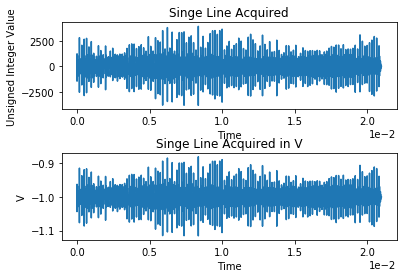

In [2]:
%matplotlib inline

import scipy as Sci
import scipy.linalg
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from scipy.signal import hilbert

f = open('LabRFdata.bin','rb')   
Line = np.fromfile(f,count=-1,dtype=np.int16)
L=len(Line)
print(+L)
f.close() 
x=np.arange(0,L/25e6,1/25e6) 
plt.subplots_adjust( hspace = .5 )
plt.subplot(211)
plt.plot(x,Line[:L])
plt.title('Singe Line Acquired')
plt.xlabel('Time')
plt.ylabel('Unsigned Integer Value')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
LineF=Line.astype(np.float64)
LineF/=(2**15-1)
LineF-=1.
plt.subplot(212)
plt.plot(x,LineF[:L])
plt.title('Singe Line Acquired in V')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

We will analyze this signal visually (zoom) to estimate the frequency of the transducer used.

We will then perform a Fourier transform to obtain the central frequency of the transducer.

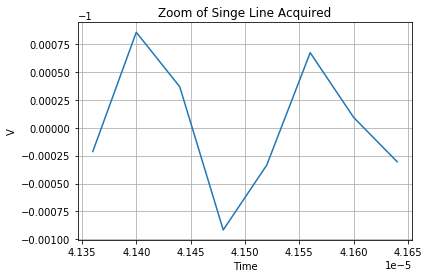

In [3]:
inx1=np.where(x>0.4134e-4)
inx1=inx1[0]
inx2=np.where(x>0.4164e-4)
inx2=inx2[0]
plt.plot(x[inx1[0]:inx2[0]],LineF[inx1[0]:inx2[0]])
plt.title('Zoom of Singe Line Acquired')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.grid()

Since 1.5 cycles of the signal are between $0.4134\times 10^{-4}$ and $0.4164\times ^{-4}$ we then have a frequency of $\frac{1}{(0.4164\times 10^{-4}-0.4134\times 10^{-4})/1.5}=4.4MHz$

We will now obtain this using DFT. Note: just as we did before, we will take away the dc component!

The maximum is 0.000082 and it is found at index 125312 which is the frequency 5.975342e+06


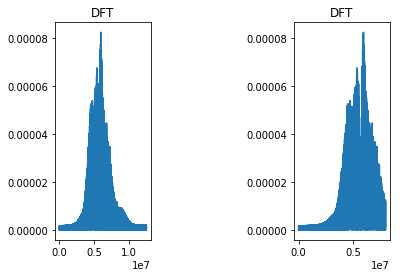

In [7]:
#Eliminating dc
LineF-=np.mean(LineF)
f=np.arange(0,25e6/2,25e6/L)
Y=np.fft.fft(LineF)
Pyy=abs(Y)/L

plt.subplots_adjust( wspace = 1.5 )
plt.subplot(121)
L2=len(Pyy)/2

plt.plot(f[:L2], Pyy[:L2])
plt.title('DFT')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

inx=np.where(f>8e6)
inx=inx[0]
plt.subplot(122)
plt.plot(f[:inx[0]], Pyy[:inx[0]])
plt.title('DFT')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#Let's obtain the frequency at which the maximum is observed
#Remember we have a DFT which is mirrored, so we only work with half
PyyM=Pyy[:L2]
mm=np.argmax(PyyM) #this gives the index where the max is found
print("The maximum is %f and it is found at index %d which is the frequency %e" % (max(PyyM),mm,f[mm]))

We can see that the frequency of that transducer is $5.97MHz$ and as you can see, using the DFT gave us more precision than estimation.

Assuming that the tissues have attenuated this signal $4Np/m/MHz$ we will compensate for this attenuation and plot the real time-gain-compensated signal. The attenuation is exponential so we can compensate using:

$$ RF_{com}=RF e^{\mu d}\;\;\mu=\alpha f\;\;\;\;\;d=ct\;\;\;c\approx 1450m/s$$


H:\anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


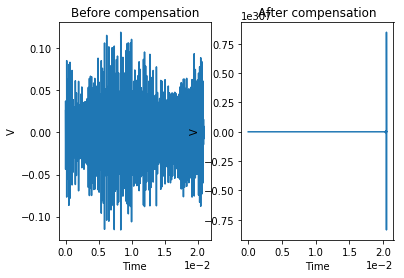

In [5]:
#Compensating
h=x*1450
ffatt=np.exp(4*5.97*h)
LineC=LineF*ffatt
#Plotting
plt.subplot(121)
plt.plot(x,LineF[:L])
plt.title('Before compensation')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(122)
plt.plot(x,LineC[:L])
plt.title('After compensation')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

The total lines are:128
(128L, 2000L)


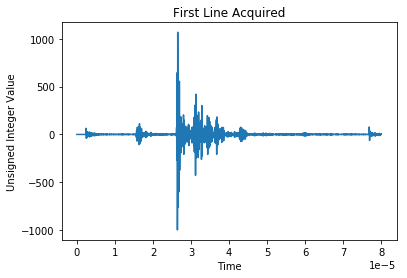

In [10]:
#we have the lines in RFLines
LE=4096
#we will now populate a 2D matrix for the lines
TL=len(Line)/LE
print('The total lines are:'+str(TL))
RFLinesF=Line*1.-np.mean(Line*1.)
LinesRF=RFLinesF.reshape(TL,LE).copy()  #columns,rows
#limiting all the lines
LinesRF[:,0:60]=0
LinesRFLim=LinesRF[:,0:2000]
xLim=x[0:2000]
hLim=h[0:2000]
#now we plot two lines acquired to double check 
print(np.shape(LinesRFLim))
plt.subplots_adjust( hspace = .5 )
plt.plot(xLim,LinesRFLim[0,:]) #first line
plt.title('First Line Acquired')
plt.xlabel('Time')
plt.ylabel('Unsigned Integer Value')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


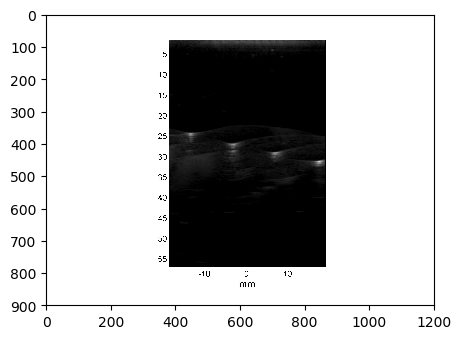

In [6]:
from skimage import novice, data, io, exposure
import matplotlib.image as mpimg
import scipy.ndimage as ndimage
from scipy.signal import medfilt
img = novice.open('picture.jpg')
ima= mpimg.imread('picture.jpg','True') 
image = ndimage.median_filter(ima,3)
fig=plt.figure(figsize=(5,5), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(image)
plt.show()
